# Pre-Processing and Training Data


From the EDA we were able to determined what seemed like the best opening for white. We were able to determine that Queen's Gambit Accepted seems to be one of the most popular and successful openings for white. 

Next we want to determine what predicts the outcome of games that we deem a "fair fight". Is it elo difference, time, moving first (white), increment, or opening choice. 
In this notebook, we will start to build machine learning models. 


In [2]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale, OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression, LinearRegression
import category_encoders as ce
import datetime
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn.tree import export_graphviz



In [3]:
# Load the dataset into a pandas dataframe
df2 = pd.read_csv('df_EDA_result.csv', index_col=[0])

In [4]:
df = df2
df = df.reset_index(drop=True)


While we would love to look at everything, we are unfotunetly running into memory issues again. We will have to remove some data. We will be removing the following data to make it easier for the computer to handle. 
- Elo difference absolute - While this data is important to see trends in wins elo difference give us a fuller picture. 
- White / Black first move - This data is theoratically covered by opening. 
- Game URL - This shouldn't inflence anything. 
- Termination - This tells us how the game finished not who won. 

Furthermore, we will be:
- Changing Time Control: Increment to just a 1 or a 0 (yes or no).
- Combining Opening and Opening Variation and then looking at the most popular of those. 

In [5]:
'''Preprocess the chess game data by concatenating two existing columns, 
removing an unnecessary column, and cleaning up any resulting data inconsistencies.'''

df["Opening"] = df.apply(lambda x: str(x["Opening"]) + ":" + str(x["Opening Variation"]), axis=1)
df.drop("Opening Variation", axis=1, inplace=True)
df['Opening'] = df['Opening'].str.replace(':nan', '')

In [5]:
'''Analyze the frequency of different chess game openings in the dataset.'''

pd.set_option('display.max_rows', df.shape[0]+1)
df['Opening'].value_counts(normalize=True).cumsum().head(192)

Queen's Pawn Game                                                   0.025336
Modern Defense                                                      0.049011
Scandinavian Defense: Mieses-Kotroc Variation                       0.070687
Philidor Defense                                                    0.091794
Queen's Pawn Game: Mason Variation                                  0.111829
Caro-Kann Defense                                                   0.131440
Van't Kruijs Opening                                                0.146249
Horwitz Defense                                                     0.160365
Pirc Defense                                                        0.174063
French Defense: Knight Variation                                    0.187458
Scandinavian Defense                                                0.199824
Indian Defense                                                      0.211940
Owen Defense                                                        0.223732

In [6]:
'''Filter the chess game data to include only the most common openings.'''

mask = df['Opening'].isin(df['Opening'].value_counts(normalize=True).cumsum().head(192).index)
df = df[mask]

In [7]:
# dropping columns
df.drop(columns=['Elo Difference Absolute', 'White First Move', 'Black First Move', 'Game URL', 'Termination'], inplace=True)

In [8]:
# changing Time Control: Increment to just 1 or 0. 
df['Time Control: Increment'] = df['Time Control: Increment'].apply(lambda x: 0 if x == 0 else 1)

In [9]:
print(df.dtypes)

Opening                     object
White Elo                    int64
Black Elo                    int64
Elo Difference               int64
White Won                  float64
Time Control                 int64
Time Control: Increment      int64
dtype: object


In [10]:
# converting to int16 to save memory.
cols_to_convert = ["White Elo", "Black Elo", "Elo Difference"]
df[cols_to_convert] = df[cols_to_convert].astype('int64')
# converting to category to save memory.
cols_to_convert2 = ["Time Control: Increment", "Time Control", "Opening"]
df[cols_to_convert2] = df[cols_to_convert2].astype('category')


In [11]:
'''Clean up the chess game results data by replacing numerical values with more descriptive labels. '''

df["White Won"] = df["White Won"].astype(str)
df["White Result"] = df["White Won"].str.replace(re.escape('0.5'), 'Drawn') \
                                                .str.replace(re.escape('1.0'), 'Won') \
                                                .str.replace(re.escape('0.0'), 'Lost') 

C:\Users\PC\AppData\Local\Temp\ipykernel_18880\2398043986.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df["White Result"] = df["White Won"].str.replace(re.escape('0.5'), 'Drawn') \


In [12]:
# dropping columns
df.drop(columns=['White Won'], inplace=True)

In [13]:
print(df.dtypes)

Opening                    category
White Elo                     int64
Black Elo                     int64
Elo Difference                int64
Time Control               category
Time Control: Increment    category
White Result                 object
dtype: object


In [14]:
df.head()

,Opening,White Elo,Black Elo,Elo Difference,Time Control,Time Control: Increment,White Result
0,Sicilian Defense: Bowdler Attack,1429,1460,-31,300,1,Won
1,King's Pawn Game: Leonardis Variation,1687,1647,40,300,1,Won
3,Queen's Gambit Declined: Marshall Defense,1101,1086,15,300,1,Lost
4,Sicilian Defense: Smith-Morra Gambit,1362,1408,-46,300,1,Lost
6,Queen's Gambit Declined: Baltic Defense,1175,1228,-53,300,1,Lost


In [15]:
df.shape

(27172292, 7)

# Train/Test Split


In [16]:
# What partition sizes would you have with a 70/30 train/test split?
len(df) * .7, len(df) * .3, 

(19020604.4, 8151687.6)

In [17]:
'''Split the chess game data into training and test sets for use in machine learning models'''

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='White Result'), 
                                                    df['White Result'], test_size=0.7, 
                                                    random_state=47)


In [18]:
# Get a list of the numeric features
numeric_features = X_train.select_dtypes(include='number').columns.tolist()

# Get a list of the categorical features
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['White Elo', 'Black Elo', 'Elo Difference', 'Opening', 'Time Control', 'Time Control: Increment']


In [19]:
X_train.shape, X_test.shape

((8151687, 6), (19020605, 6))

In [20]:
y_train.shape, y_test.shape

((8151687,), (19020605,))

In [21]:
'''Build a machine learning pipeline to preprocess the chess game
data and train a random forest classifier model.'''

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on train and test
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Test Accuracy', pipeline.score(X_test, y_test))

Train Accuracy 0.9531440547214337
Test Accuracy 0.4811738638176861


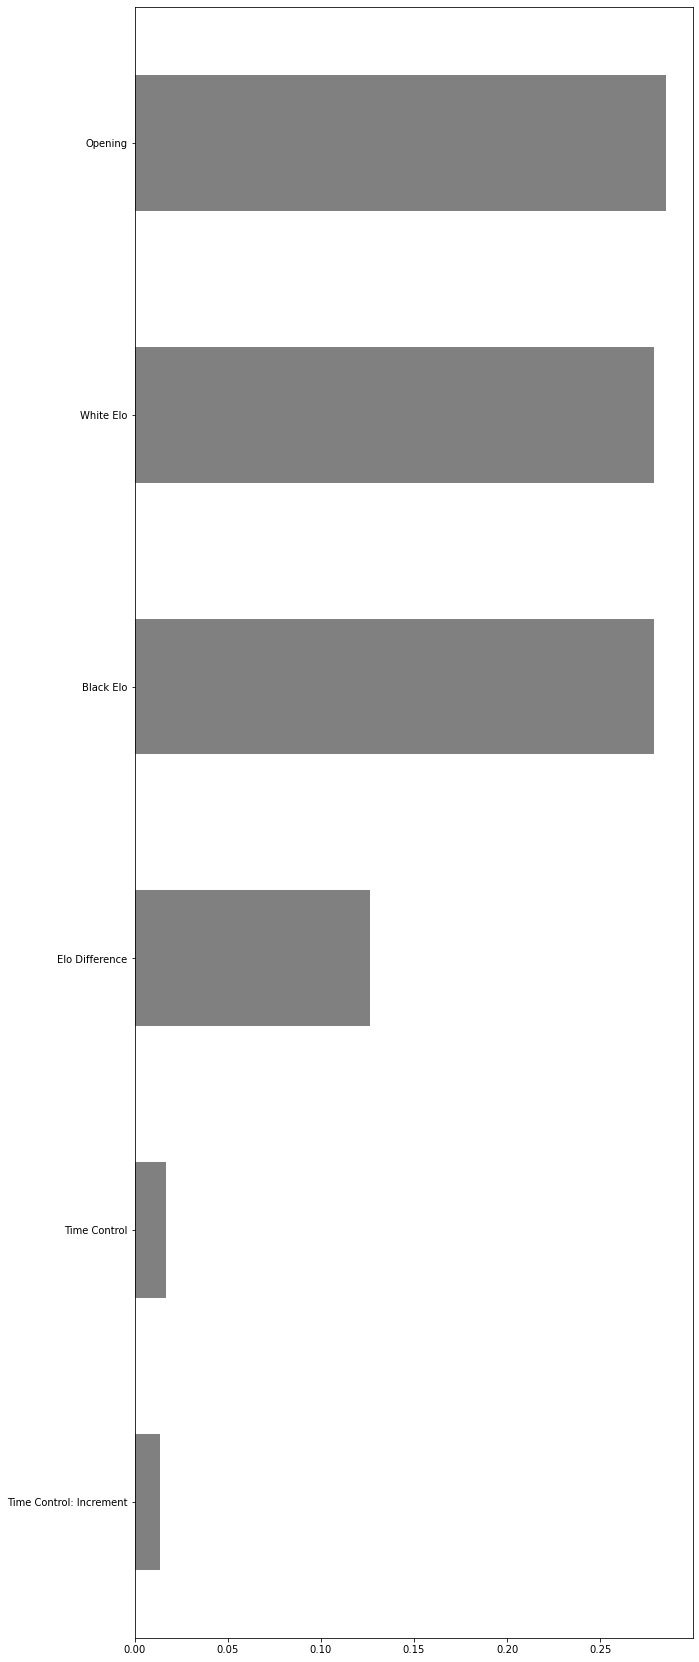

In [22]:
'''visualize the feature importances of the random forest classifier model trained 
in the previous section. Feature importances tell us which features the model 
considered to be most important in making predictions.'''


%matplotlib inline

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_test).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey');

Train Accuracy 0.5102060469201037
Test Accuracy 0.510206221095491


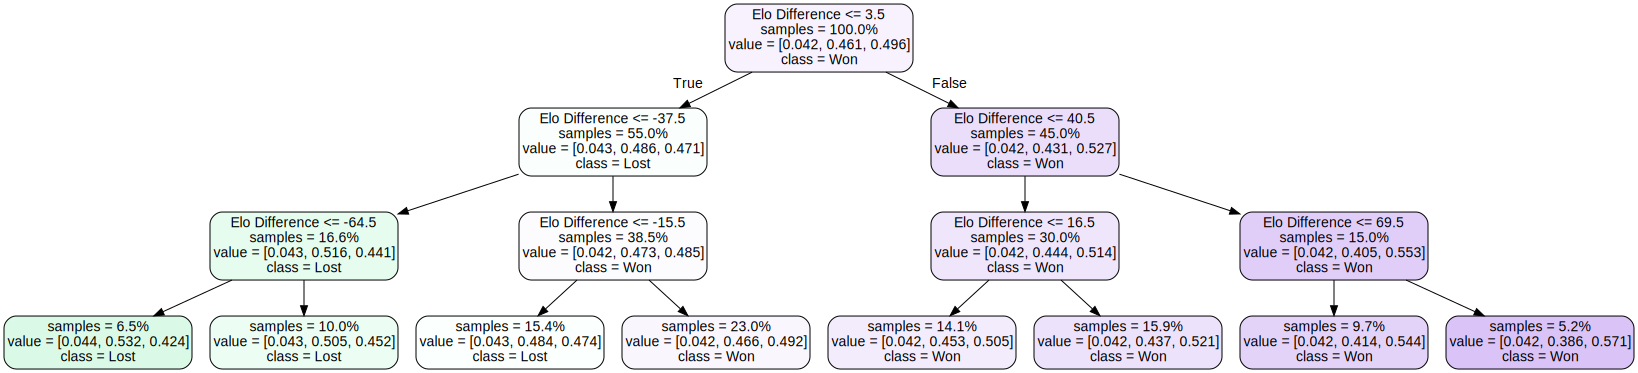

In [23]:
'''build a decision tree classifier using the same data and preprocessing steps as before, 
but this time using a decision tree classifier instead of a random forest classifier. 
We'll also visualize the resulting decision tree to gain insight into how it's making predictions.'''

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    DecisionTreeClassifier(max_depth=3, random_state=42)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on train and test
print('Train Accuracy', pipeline.score(X_train, y_train))
print('Test Accuracy', pipeline.score(X_test, y_test))

#make decision tree 
model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_test).columns

dot_data = export_graphviz(model, 
                           out_file=None, 
                           max_depth=3, 
                           feature_names=encoded_columns,
                           class_names=model.classes_, 
                           impurity=False, 
                           filled=True, 
                           proportion=True, 
                           rounded=True)   
display(graphviz.Source(dot_data))

In summary, the above preprocesses, trains, and models a dataset of chess game outcomes. Two models, a decision tree model and a random forest model, were built using these datasets.

Unfortunately, the results indicate that both models have a high accuracy rate, but there is an issue of overfitting, suggesting the models are not performing well on new data. Further iterations could be made to improve the models' performance.

The feature importance of the model is visualized using a horizontal bar plot, and the plot reveals that the most important feature is opening, followed by elo, and then elo difference.

Additionally, the report concludes that the data gathered from the EDA provides insight into the success of each opening, which could be further explored to improve model performance.

Specifically, the decision tree model had a train and test accuracy of 0.51, which is only slightly more accurate than a coin flip. Meanwhile, the random forest model had a high train accuracy of 0.95, but a lower test accuracy of 0.48. This discrepancy is likely due to overfitting, indicating that further iterations and adjustments are needed for better model performance.